# UFC Round Win Prediction Model

## Imports & Setup

In [1]:
import os
import matplotlib

from ufcdata.query import DatabaseQuery
from ufcdata.tools import query_to_df

import pandas as pd
import numpy as np
import kmapper as km
import matplotlib.pyplot as plt

%config InlineBackend.figure_format='retina'
plt.rcParams['font.family'] = 'SF Mono'

import seaborn as sb
import pickle as pkl

from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans

from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import warnings

warnings.filterwarnings('ignore')


In [2]:
ROOT_DIR = os.path.dirname(os.path.abspath("top_level_file.txt"))
DATA_DIR = os.path.join(ROOT_DIR, 'data')
DATA_PATH = os.path.join(DATA_DIR, 'ML_data.pkl')
MODEL_PATH = os.path.join(DATA_DIR, 'mlp_trained_model.pkl')

## Data Retrieval

In [33]:
# Query for all fights and filter for fights that were finished by KO / submission

DQ = DatabaseQuery()

query = DQ.engine.execute('SELECT * from fights')

df_all_fights = query_to_df(query)
df_all_fights['rd_id'] = df_all_fights['fight_id'] + '-' + df_all_fights['rd_ended'].astype(str)
df_fights_finished = df_all_fights.loc[(df_all_fights['method'].str.contains('KO')) | (df_all_fights['method'].str.contains('Sub'))]

df_fights_finished.head()
df_fights_finished['...'] = "..."

print(df_fights_finished[['fight_id', 'referee', 'method', '...']].head().to_markdown())

|    | fight_id         | referee         | method     | ...   |
|---:|:-----------------|:----------------|:-----------|:------|
|  1 | 31c2d8648b06a001 | Josh Rosenthal  | KO/TKO     | ...   |
|  2 | 0064bbc554d85421 | Herb Dean       | Submission | ...   |
|  6 | aec1339028f3416c | Blake Grice     | KO/TKO     | ...   |
| 12 | aa430402314b4459 | Kevin MacDonald | KO/TKO     | ...   |
| 15 | bf2a9732af50c84c | Dan Miragliotta | KO/TKO     | ...   |


In [4]:
# Query for all round stats

query = DQ.engine.execute('SELECT * from round_stats')

df_all_round_stats = query_to_df(query)
df_all_round_stats['fight_id'] = df_all_round_stats['rd_id'].str[:-2]

df_all_round_stats.head()

,id,rd_result_id,fighter_id,opponent_id,rd_id,kd,sig_head_made,sig_head_att,sig_body_made,sig_body_att,...,opp_sig_ground_att,opp_tot_str_made,opp_tot_str_att,opp_takedown_made,opp_takedown_att,opp_sub_att,opp_reversals,opp_ctrl,create_date,fight_id
0,64281,c078544a32e18ba3-1-4d74641fac830182,4d74641fac830182,979f7edbb6980b0d,c078544a32e18ba3-1,0,9,14,5,9,...,5,43,60,0,0,0,0,258.0,2022-08-23,c078544a32e18ba3
1,64282,c078544a32e18ba3-1-979f7edbb6980b0d,979f7edbb6980b0d,4d74641fac830182,c078544a32e18ba3-1,0,6,20,13,14,...,0,44,54,0,2,0,0,0.0,2022-08-23,c078544a32e18ba3
2,64283,c078544a32e18ba3-2-4d74641fac830182,4d74641fac830182,979f7edbb6980b0d,c078544a32e18ba3-2,0,4,9,0,0,...,14,20,34,1,1,0,0,251.0,2022-08-23,c078544a32e18ba3
3,64284,c078544a32e18ba3-2-979f7edbb6980b0d,979f7edbb6980b0d,4d74641fac830182,c078544a32e18ba3-2,0,3,13,2,2,...,4,44,52,0,0,0,1,23.0,2022-08-23,c078544a32e18ba3
4,70773,aa4aa75f0065a687-1-473ce3aa581251a2,473ce3aa581251a2,91acd6910b802a9e,aa4aa75f0065a687-1,0,20,75,1,3,...,0,43,93,0,0,0,0,0.0,2022-08-23,aa4aa75f0065a687


In [5]:
# Query for all round scores with a KO / submission

query = DQ.engine.execute('SELECT * from rounds')

df_all_rounds = query_to_df(query)
df_all_finish_rounds_filtered = df_all_rounds.loc[df_all_rounds['rd_id'].isin(df_fights_finished['rd_id'])]

df_all_finish_rounds_filtered.head()

,id,rd_id,fight_id,rd_num,rd_length,judge1_fighter1,judge1_fighter2,judge2_fighter1,judge2_fighter2,judge3_fighter1,judge3_fighter2,create_date
2,42324,921a8db065cd8cc5-2,921a8db065cd8cc5,2,246,NaN,NaN,NaN,NaN,NaN,NaN,2022-08-23
5,42325,69b147aaaafeb47d-1,69b147aaaafeb47d,1,33,NaN,NaN,NaN,NaN,NaN,NaN,2022-08-23
8,42327,326c3eaa1e9e3dc4-2,326c3eaa1e9e3dc4,2,125,NaN,NaN,NaN,NaN,NaN,NaN,2022-08-23
9,42334,8b1dc96a00a8e881-1,8b1dc96a00a8e881,1,213,NaN,NaN,NaN,NaN,NaN,NaN,2022-08-23
11,42336,20b5de395c0f1375-2,20b5de395c0f1375,2,107,NaN,NaN,NaN,NaN,NaN,NaN,2022-08-23


In [6]:
# Merge all rounds scored or finished

df_rounds_scored = query_to_df(DQ.get_round_scoring())
df_total_rounds = pd.concat([df_rounds_scored, df_all_finish_rounds_filtered])
df_total_rounds['f1_tot'] = df_total_rounds['judge1_fighter1'] + df_total_rounds['judge2_fighter1'] + df_total_rounds['judge3_fighter1']
df_total_rounds['f2_tot'] = df_total_rounds['judge1_fighter2'] + df_total_rounds['judge2_fighter2'] + df_total_rounds['judge3_fighter2']
df_total_rounds = pd.merge(df_total_rounds, df_all_fights[['rd_id', 'method', 'winner_id']], how='left', on='rd_id')
df_total_rounds = pd.merge(df_total_rounds, df_all_fights[['fight_id', 'fighter_1_id', 'fighter_2_id', 'weight_class']], how='left', on='fight_id')

df_total_rounds.head()

,id,rd_id,fight_id,rd_num,rd_length,judge1_fighter1,judge1_fighter2,judge2_fighter1,judge2_fighter2,judge3_fighter1,judge3_fighter2,create_date,f1_tot,f2_tot,method,winner_id,fighter_1_id,fighter_2_id,weight_class
0,43880,7feadf01c5920285-1,7feadf01c5920285,1,300,9.0,10.0,10.0,9.0,10.0,9.0,2022-08-23,29.0,28.0,NaN,NaN,6d4b63c767106d3a,f2b6fdb20675b11c,Welterweight
1,43881,7feadf01c5920285-2,7feadf01c5920285,2,300,9.0,10.0,9.0,10.0,9.0,10.0,2022-08-23,27.0,30.0,NaN,NaN,6d4b63c767106d3a,f2b6fdb20675b11c,Welterweight
2,43882,7feadf01c5920285-3,7feadf01c5920285,3,300,10.0,9.0,10.0,9.0,10.0,9.0,2022-08-23,30.0,27.0,Decision - Split,6d4b63c767106d3a,6d4b63c767106d3a,f2b6fdb20675b11c,Welterweight
3,42331,b3096e8dd4e90718-1,b3096e8dd4e90718,1,300,10.0,9.0,10.0,9.0,10.0,9.0,2022-08-23,30.0,27.0,NaN,NaN,2eeaefbfc7f9fcff,016a8d958883167c,Women's Bantamweight
4,42345,cd117bfce747184f-1,cd117bfce747184f,1,300,10.0,9.0,10.0,9.0,9.0,10.0,2022-08-23,29.0,28.0,NaN,NaN,4a28cb716c19157a,9ce6d5a03af801b7,Welterweight


## Data Integration & Clean-up

In [7]:
# Build new dataframe for each fighter's round and its result

df = pd.DataFrame()

df[['fight_id', 'fighter_id', 'opponent_id', 'rd_id']] = df_all_round_stats[['fight_id', 'fighter_id', 'opponent_id', 'rd_id']]
df = df.loc[df['rd_id'].isin(df_total_rounds['rd_id'])]
df['rd'] = df['rd_id'].str[-1].astype(int)
df['KO'] = 0
df['SUB'] = 0
df = pd.merge(df, df_total_rounds[['fight_id', 'rd_id', 'weight_class']], how='left', on=['fight_id', 'rd_id'])

for i in df.index:
    ftr_id = df.at[i, 'fighter_id']
    rd_id = df.at[i, 'rd_id']
    df_red = df_total_rounds.loc[((df_total_rounds['fighter_2_id'] == ftr_id) | (df_total_rounds['fighter_1_id'] == ftr_id)) & (df_total_rounds['rd_id'] == rd_id)]
    
    try:
        df.at[i, 'KO'] = 1 if 'KO' in df_red['method'].item() and ftr_id == df_red['winner_id'].item() else 0
        df.at[i, 'SUB'] = 1 if 'Sub' in df_red['method'].item() and ftr_id == df_red['winner_id'].item() else 0
    except:
        pass
    
    df.at[i, 'rd_won'] = df.at[i, 'KO'] + df.at[i, 'SUB']
    
    if pd.notna(df_red['f1_tot'].item()):
        if ftr_id == df_red['fighter_1_id'].item() and df_red['f1_tot'].item() > df_red['f2_tot'].item():
            df.at[i, 'rd_won'] = 1
        elif ftr_id == df_red['fighter_2_id'].item() and df_red['f1_tot'].item() < df_red['f2_tot'].item():
            df.at[i, 'rd_won'] = 1
        
df.head()

,fight_id,fighter_id,opponent_id,rd_id,rd,KO,SUB,weight_class,rd_won
0,aa4aa75f0065a687,473ce3aa581251a2,91acd6910b802a9e,aa4aa75f0065a687-3,3,0,0,Welterweight,0.0
1,aa4aa75f0065a687,91acd6910b802a9e,473ce3aa581251a2,aa4aa75f0065a687-3,3,0,1,Welterweight,1.0
2,9468f58f8abf78df,e0b74df14f52cd15,80dbeb1dd5b53e64,9468f58f8abf78df-1,1,0,0,Featherweight,1.0
3,9468f58f8abf78df,80dbeb1dd5b53e64,e0b74df14f52cd15,9468f58f8abf78df-1,1,0,0,Featherweight,0.0
4,bfb468c3427faa50,029880cdbf5ca089,cb6783c39c01d896,bfb468c3427faa50-2,2,0,1,Welterweight,1.0


In [8]:
# Build new dataframe with round stat disparities for all scored and finished rounds

df_all_rounds = pd.merge(df_all_round_stats, df[['fighter_id', 'opponent_id', 'rd_id', 'rd_won']], how='left', on=['fighter_id', 'opponent_id', 'rd_id']).dropna()

df2 = df_all_rounds.copy()
df2['sig_str_made'] = df2['sig_head_made'] + df2['sig_body_made'] + df2['sig_leg_made']
df2['sig_str_att'] = df2['sig_head_att'] + df2['sig_body_att'] + df2['sig_leg_att']
df2['opp_sig_str_att'] = df2['opp_sig_head_att'] + df2['opp_sig_body_att'] + df2['opp_sig_leg_att']
df2['opp_sig_str_made'] = df2['opp_sig_head_made'] + df2['opp_sig_body_made'] + df2['opp_sig_leg_made']

offensive_stats = ['kd',
                   'sig_head_made',
                   'sig_body_made',
                   'sig_leg_made',
                   'sig_dist_made',
                   'sig_clinch_made',
                   'sig_ground_made',
                   'sig_str_made',
                   'sig_str_att',
                   'tot_str_made',
                   'tot_str_att',
                   'takedown_made',
                   'takedown_att',
                   'sub_att',
                   'reversals',
                   'ctrl'
                  ]

defensive_stats = ['opp_kd',
                   'opp_sig_head_made',
                   'opp_sig_body_made',
                   'opp_sig_leg_made',
                   'opp_sig_dist_made',
                   'opp_sig_clinch_made',
                   'opp_sig_ground_made',
                   'opp_sig_str_made',
                   'opp_sig_str_att',
                   'opp_tot_str_made',
                   'opp_tot_str_att',
                   'opp_takedown_made',
                   'opp_takedown_att',
                   'opp_sub_att',
                   'opp_reversals',
                   'opp_ctrl'
                  ]

for o, d in zip(offensive_stats, defensive_stats):
    df2[o + '_disp'] = df2[o] - df2[d]
    df2[d + '_disp'] = df2[d] - df2[o]

df2['sig_str_miss'] = df2['sig_str_att'] - df2['sig_str_made']
df2['opp_sig_str_avoid'] = df2['opp_sig_str_att'] - df2['opp_sig_str_made']
df2['sig_str_avoid_disp'] = df2['opp_sig_str_avoid'] - df2['sig_str_miss']

df2['takedown_miss'] = df2['takedown_att'] - df2['takedown_made']
df2['opp_takedown_avoid'] = df2['opp_takedown_att'] - df2['opp_takedown_made']
df2['takedown_avoid_disp'] = df2['opp_takedown_avoid'] - df2['takedown_miss']

# Final disparaties kept to train classification models

keep_columns_final = ['sig_head_made_disp', 'kd_disp', 'ctrl_disp', 'sub_att_disp', 'takedown_made_disp',
                      'reversals_disp', 'sig_str_avoid_disp', 'takedown_avoid_disp',
                      'opp_sig_str_made_disp', 'opp_takedown_made_disp', 'rd_won']

df_final = df2[keep_columns_final]

df_final.head()

,sig_head_made_disp,kd_disp,ctrl_disp,sub_att_disp,takedown_made_disp,reversals_disp,sig_str_avoid_disp,takedown_avoid_disp,opp_sig_str_made_disp,opp_takedown_made_disp,rd_won
8,-6,0,-7.0,-1,1,-1,-14,0,21,-1,0.0
9,6,0,7.0,1,-1,1,14,0,-21,1,1.0
10,30,0,246.0,0,2,0,-10,-2,-31,-2,1.0
11,-30,0,-246.0,0,-2,0,10,2,31,2,0.0
39,4,0,262.0,0,2,0,3,-1,-5,-2,1.0


## Save Final Dataset

In [9]:
with open(DATA_PATH, 'wb') as f:
    pkl.dump(df_final, f)

## Building Pipeline

In [10]:
# Build an sklearn pipeline with scalers and classifiers

preprocessor = Pipeline(
    [
        ('scaler', StandardScaler())
    ]
)

classifier = Pipeline(
    [
        ('model', SGDClassifier())
    ]
)

pipeline = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ]
)

# Differnt scaler options and classifiction models

parameters = {'preprocessor__scaler': [MinMaxScaler(), Normalizer()],
              'classifier__model': [DecisionTreeClassifier(), GaussianNB(), MLPClassifier()]}

## Random Grid Search Setup

In [11]:
# Use Randomized Grid search to find the best scoring pipeline among all variations

cv = KFold(n_splits=10)

X, y = df_final.iloc[:, :-1].to_numpy(), df_final.iloc[:, -1].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1042)

grid = RandomizedSearchCV(pipeline, parameters, cv=cv)

## Fitting

In [12]:
grid.fit(X_train, y_train)

RandomizedSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('preprocessor',
                                              Pipeline(steps=[('scaler',
                                                               StandardScaler())])),
                                             ('classifier',
                                              Pipeline(steps=[('model',
                                                               SGDClassifier())]))]),
                   param_distributions={'classifier__model': [DecisionTreeClassifier(),
                                                              GaussianNB(),
                                                              MLPClassifier()],
                                        'preprocessor__scaler': [MinMaxScaler(),
                                                                 Normalizer()]})

In [13]:
df_results = pd.DataFrame(grid.cv_results_)
df_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__scaler,param_classifier__model,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.038232,0.000939,0.000616,0.000139,MinMaxScaler(),DecisionTreeClassifier(),"{'preprocessor__scaler': MinMaxScaler(), 'clas...",0.837889,0.814367,0.797203,0.814367,0.800381,0.828989,0.812460,0.792753,0.820089,0.814885,0.813339,0.013231,5
1,0.107400,0.002813,0.000553,0.000085,Normalizer(),DecisionTreeClassifier(),"{'preprocessor__scaler': Normalizer(), 'classi...",0.837254,0.808010,0.785760,0.817546,0.794660,0.820089,0.823268,0.801017,0.821360,0.813613,0.812258,0.014409,6
2,0.002739,0.000087,0.000403,0.000004,MinMaxScaler(),GaussianNB(),"{'preprocessor__scaler': MinMaxScaler(), 'clas...",0.870312,0.863954,0.834711,0.871583,0.851240,0.865226,0.861411,0.855690,0.864590,0.849873,0.858859,0.010634,3
3,0.002401,0.000008,0.000421,0.000004,Normalizer(),GaussianNB(),"{'preprocessor__scaler': Normalizer(), 'classi...",0.835982,0.821996,0.790846,0.841704,0.825175,0.825811,0.819453,0.821360,0.834711,0.817430,0.823447,0.013219,4
4,4.516609,1.485819,0.003490,0.004032,MinMaxScaler(),MLPClassifier(),"{'preprocessor__scaler': MinMaxScaler(), 'clas...",0.893833,0.876669,0.853783,0.883026,0.871583,0.883026,0.879212,0.867769,0.882390,0.877863,0.876915,0.010219,1
5,10.512598,0.476991,0.001717,0.001407,Normalizer(),MLPClassifier(),"{'preprocessor__scaler': Normalizer(), 'classi...",0.886840,0.870947,0.844882,0.881119,0.861411,0.871583,0.872854,0.861411,0.879847,0.872774,0.870367,0.011404,2


{'preprocessor__scaler': MinMaxScaler(), 'classifier__model': MLPClassifier()}
Pipeline(steps=[('preprocessor', Pipeline(steps=[('scaler', MinMaxScaler())])),
                ('classifier', Pipeline(steps=[('model', MLPClassifier())]))])
0.8716383749761587


Text(0.5, 1.0, 'Classification Model Comparison')

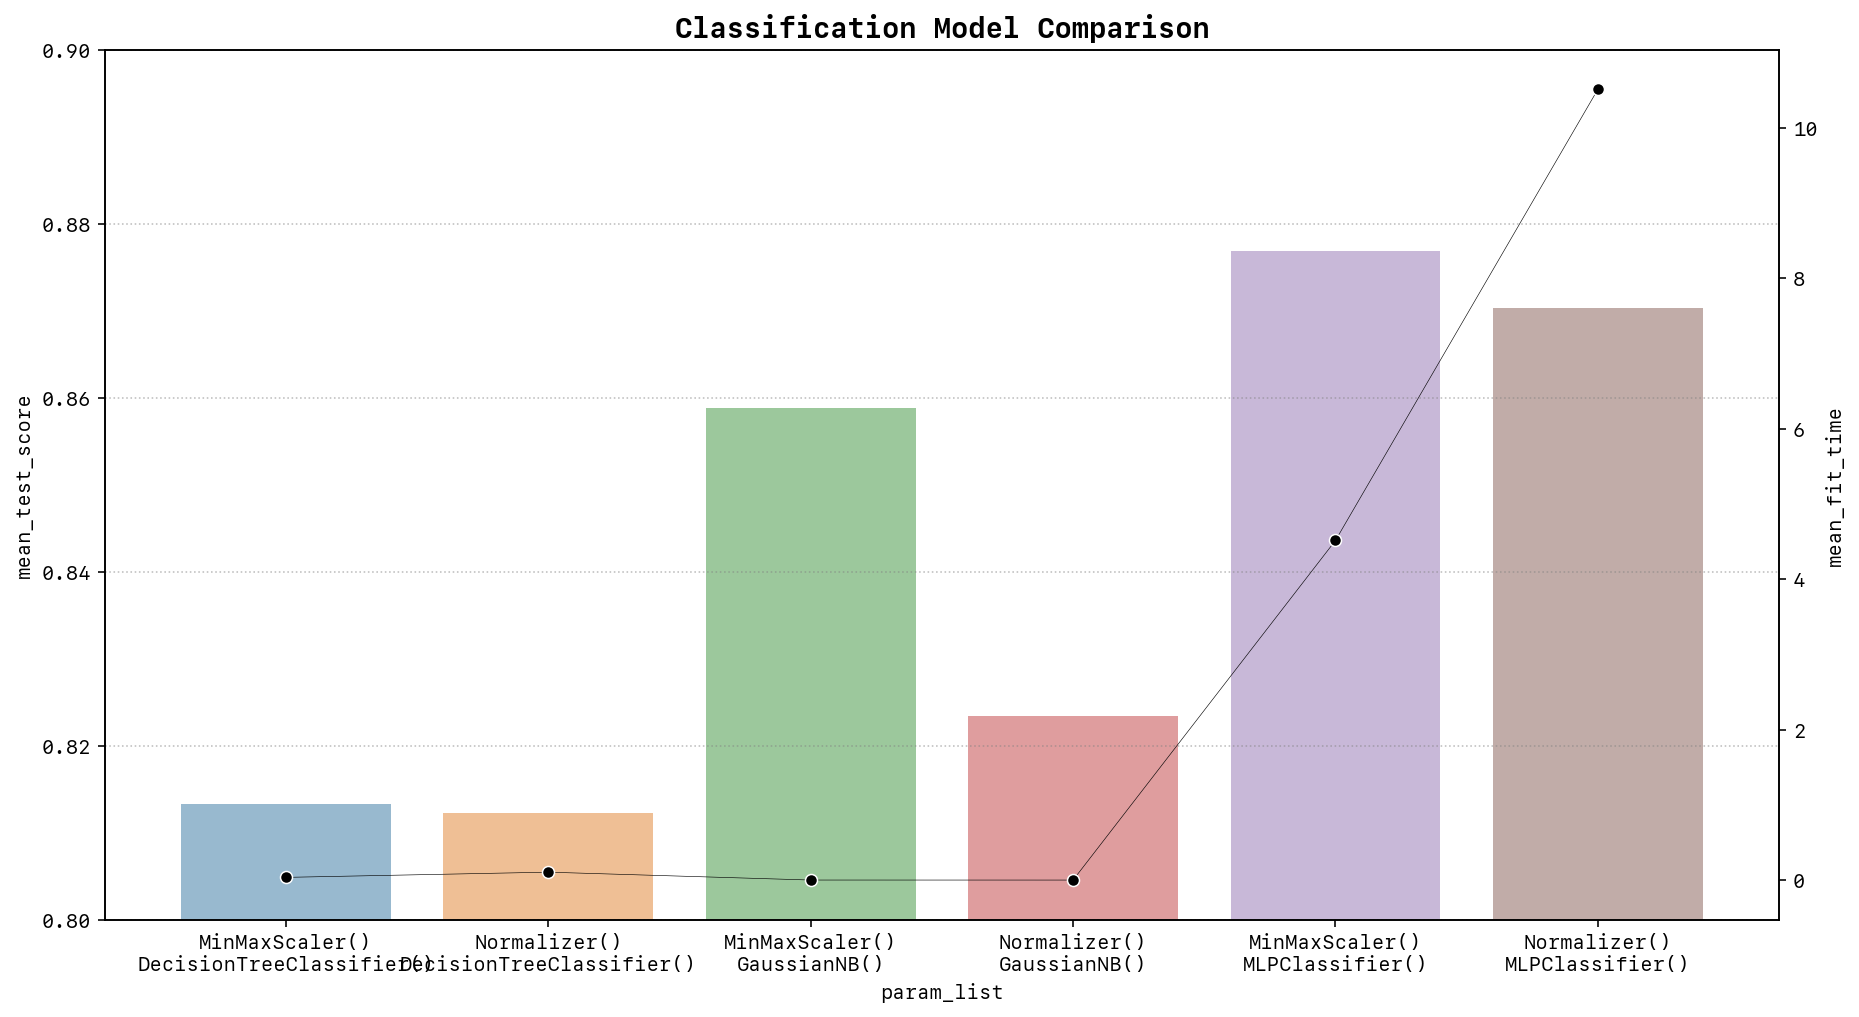

In [14]:
# Comparison of different model variations and yielding the best classification model

print(grid.best_params_)
print(grid.best_estimator_)
print(grid.score(X_test, y_test))

for i in df_results.index:
    df_results.at[i, 'param_list'] = "\n".join([str(v) for k, v in list(df_results.at[i, 'params'].items())])

fig, ax = plt.subplots(figsize=(15, 8))
ax2 = ax.twinx()
ax.grid(ls=':', color='grey', alpha=0.5)

bar = sb.barplot(x='param_list', y='mean_test_score', data=df_results, alpha=0.5, ax=ax)
plot = sb.lineplot(x='param_list', y='mean_fit_time', data=df_results, ax=ax2, color='black', marker='o', linewidth=0.3)
ax.set_ylim((0.8, 0.9))
ax.set_title('Classification Model Comparison', fontsize=14, weight='bold')

## Hyperparameter Tuning for MLPClassifier

In [15]:
# Rebuilding pipeline with chosen MLP classifier for hyperparam optimization

preprocessor = Pipeline(
    [
        ('scaler', MinMaxScaler())
    ]
)

classifier = Pipeline(
    [
        ('mlp', MLPClassifier())
    ]
)

pipeline = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ]
)

# Selected hyperparameters

parameters = {'classifier__mlp__hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
              'classifier__mlp__activation': ['tanh', 'relu'],
              'classifier__mlp__solver': ['sgd', 'adam'],
              'classifier__mlp__alpha': [0.0001, 0.05],
              'classifier__mlp__learning_rate': ['constant','adaptive']}

grid = RandomizedSearchCV(pipeline, parameters, cv=cv).fit(X_train, y_train)

In [16]:
print(grid.best_params_)
print(grid.best_estimator_)
print(grid.score(X_test, y_test))

df_results = pd.DataFrame(grid.cv_results_)
df_results = df_results.sort_values('rank_test_score')

{'classifier__mlp__solver': 'sgd', 'classifier__mlp__learning_rate': 'adaptive', 'classifier__mlp__hidden_layer_sizes': (50, 50, 50), 'classifier__mlp__alpha': 0.0001, 'classifier__mlp__activation': 'relu'}
Pipeline(steps=[('preprocessor', Pipeline(steps=[('scaler', MinMaxScaler())])),
                ('classifier',
                 Pipeline(steps=[('mlp',
                                  MLPClassifier(hidden_layer_sizes=(50, 50, 50),
                                                learning_rate='adaptive',
                                                solver='sgd'))]))])
0.8731642189586115


Text(0.5, 1.0, 'Hyperparameter Tuning Comparison')

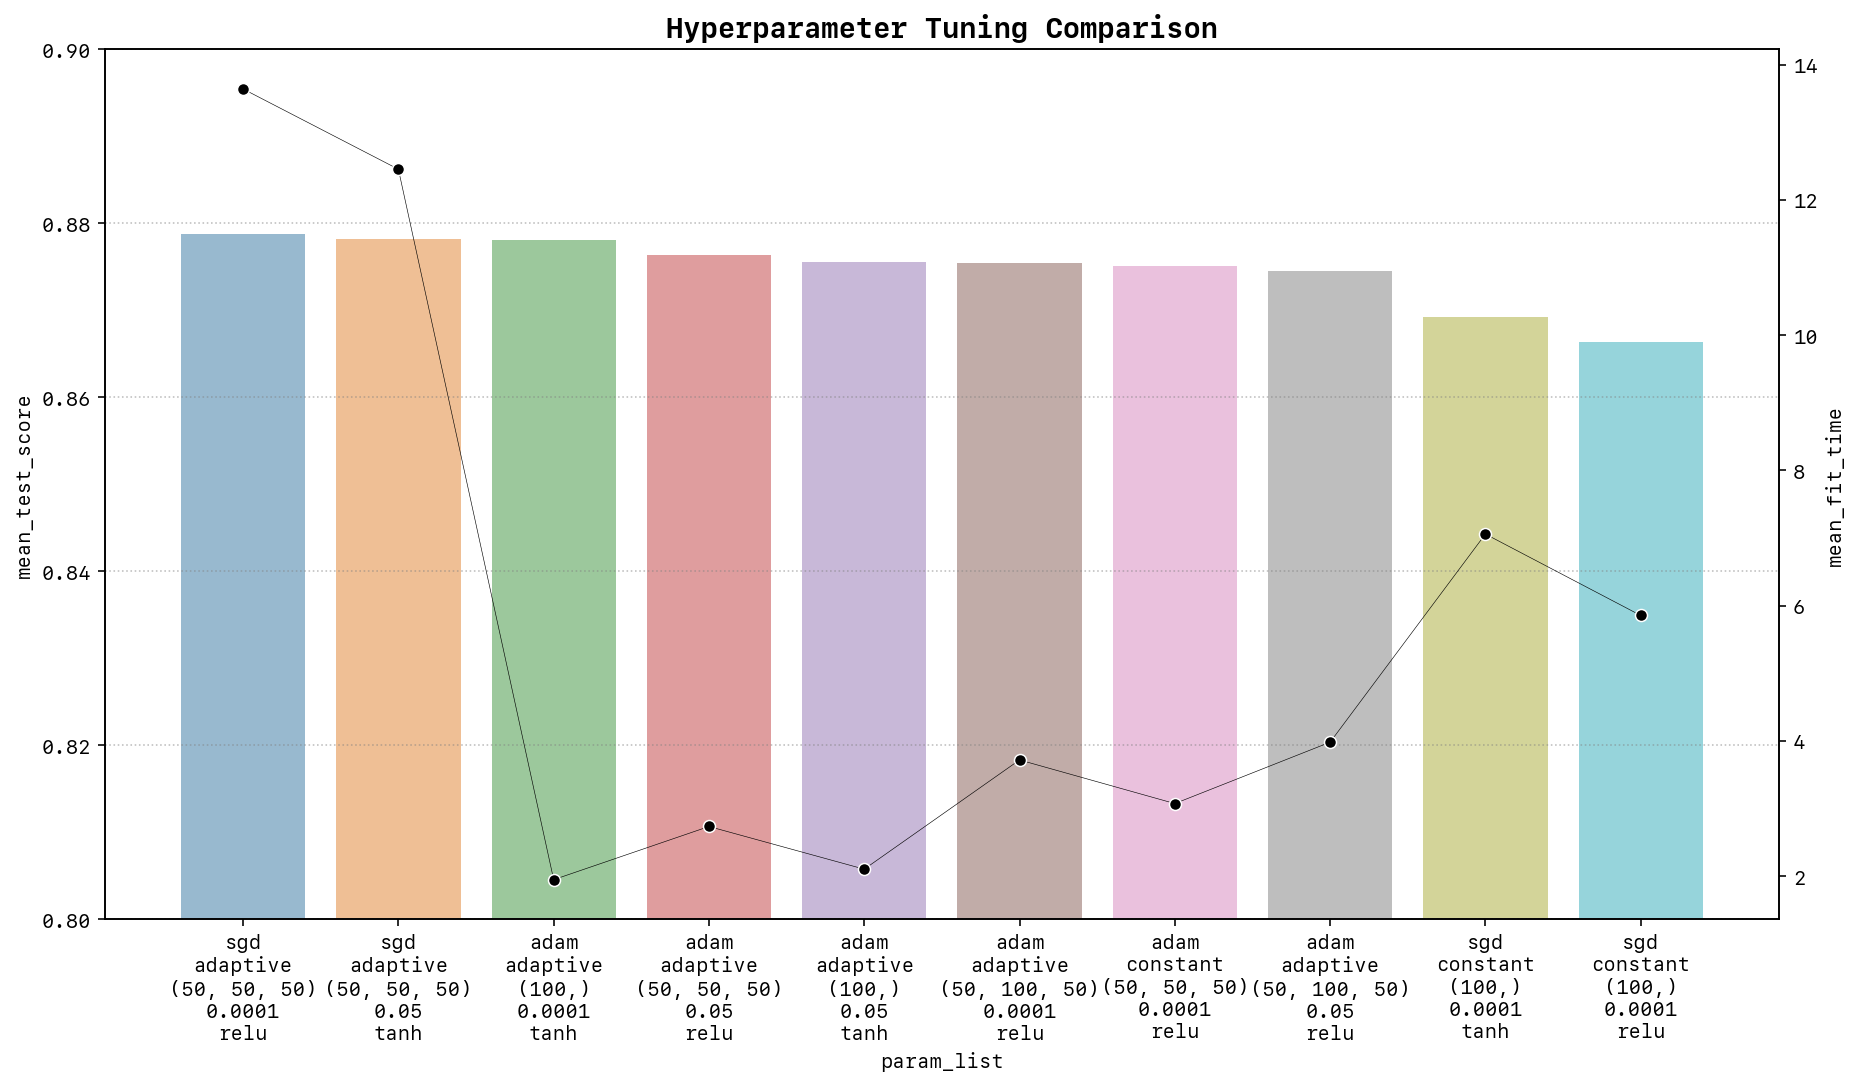

In [17]:
# Comparison of different MLP hyperparams against mean validation scores and fit times

for i in df_results.index:
    df_results.at[i, 'param_list'] = "\n".join([str(v) for k, v in list(df_results.at[i, 'params'].items())])

fig, ax = plt.subplots(figsize=(15, 8))
ax2 = ax.twinx()
ax.grid(ls=':', color='grey', alpha=0.5)

bar = sb.barplot(x='param_list', y='mean_test_score', data=df_results, alpha=0.5, ax=ax)
plot = sb.lineplot(x='param_list', y='mean_fit_time', data=df_results, ax=ax2, color='black', marker='o', linewidth=0.3)
ax.set_ylim((0.8, 0.9))
ax.set_title('Hyperparameter Tuning Comparison', fontsize=14, weight='bold')


## Classification Report

In [18]:
# Generate classification report and confusion matrix on test samples

y_true, y_pred = y_test, grid.predict(X_test)

report = pd.DataFrame(classification_report(y_true, y_pred, output_dict=True)).transpose()
report

,precision,recall,f1-score,support
0.0,0.868785,0.880970,0.874835,2638.000000
1.0,0.877726,0.865259,0.871448,2605.000000
accuracy,0.873164,0.873164,0.873164,0.873164
macro avg,0.873255,0.873115,0.873142,5243.000000
weighted avg,0.873227,0.873164,0.873152,5243.000000


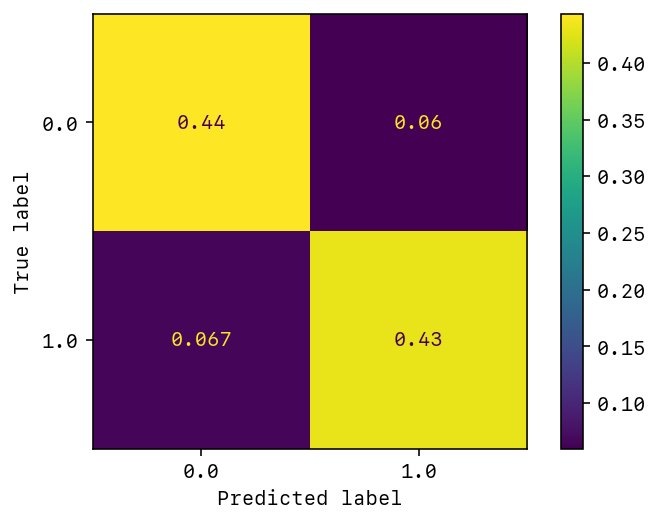

In [19]:
disp = ConfusionMatrixDisplay.from_estimator(grid, X_test, y_test, display_labels=grid.classes_, normalize='all')

In [20]:
# Get best estimator from model variants

pipeline = grid.best_estimator_
pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

0.8733549494564181

In [21]:
# Testing best classification model with sample data

sample = X_test[9].reshape((1, 10))

prediction = pipeline.predict(sample)
actual = y_test[9]

print(f"SAMPLE: {sample}\nACTUAL: {actual}\nPREDICTION: {prediction[0]}")

SAMPLE: [[ -4.   0. -32.   3.   0.   0.   4.  -3.   6.   0.]]
ACTUAL: 1.0
PREDICTION: 1.0


## Storing Model

In [22]:
with open(MODEL_PATH, 'wb') as f:
    pkl.dump(pipeline, f)

## Using TDA To Visually Assess Model Predictions

*NOTE* - Refer to files `true_kmapper.html` and `pred_kmapper.html` in the `data` directory for a visual comparison.

no display found. Using non-interactive Agg backend


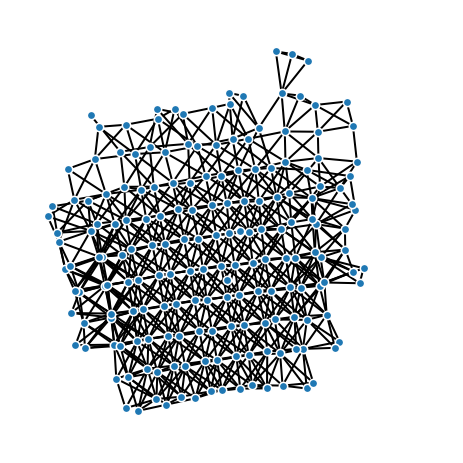

In [23]:
X, y = MinMaxScaler().fit_transform(df_final.iloc[:, :-1].to_numpy()), df_final.iloc[:, -1].to_numpy()

# Building lens 1 -> Isolation Forest
model = IsolationForest(random_state=1042).fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# Building lens 2 -> L2 Normalization
mapper = km.KeplerMapper(verbose=0)
lens2 = mapper.fit_transform(X, projection='l2norm')

lens = np.c_[lens1, lens2]

graph = mapper.map(
    lens,
    X,
    cover=km.Cover(n_cubes=10, perc_overlap=0.4),
    clusterer=KMeans(n_clusters=2, random_state=1042),
)

mapper.visualize(
    graph,
    path_html=os.path.join(DATA_DIR, "true_kmapper.html"),
    title="UFC Round Results",
    custom_tooltips=y,
    color_values=y,
    color_function_name='Win',
)

km.drawing.draw_matplotlib(graph)

no display found. Using non-interactive Agg backend


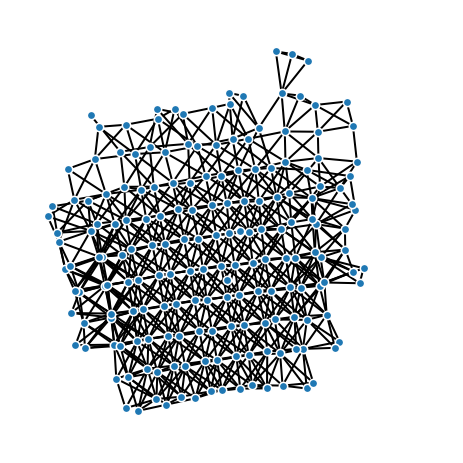

In [24]:
y_pred = pipeline.predict(df_final.iloc[:, :-1].to_numpy())

mapper.visualize(
    graph,
    path_html=os.path.join(DATA_DIR, "pred_kmapper.html"),
    title="UFC Round Results",
    custom_tooltips=y_pred,
    color_values=y_pred,
    color_function_name='Win',
)

km.drawing.draw_matplotlib(graph)